In [ ]:
import pandas as pd
import numpy as np
import torch, os, cv2, torchvision
import albumentations as A
from torchvision import transforms as T

from glob import glob
import gdown
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
def get_data(path, fl_name = "sport"):
    if os.path.isdir(path): print("Data has already downloaded") ;pass
    else:
        os.makedirs(path, exist_ok=True)
        url = 'https://drive.google.com/file/d/1CWFGa2WHTAe9eHhMcP2VWPOr4jMNkWYG/view?usp=sharing' if fl_name =="sport" else None

        data_id = url.split("/")[-2]
        prefix = "https://drive.google.com/uc?/export=download&id="

        gdown.download(prefix+data_id, path, quiet = False)
        folder = glob(f"{path}/*")[0]
        os.system(f"unzip {folder} -d {path}")
        os.remove(folder)


get_data(path="sport")

Downloading...
From: https://drive.google.com/uc?/export=download&id=1CWFGa2WHTAe9eHhMcP2VWPOr4jMNkWYG
To: /content/sport
100%|██████████| 866M/866M [00:10<00:00, 80.3MB/s]


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, im_path, im_type, transformations=None):
        super().__init__()

        self.im_path = im_path
        self.im_type = im_type
        self.transformations = transformations
        self.class_name = {}

        ds = pd.read_csv(f"{im_path}/{im_type}.csv")

        if im_type == "train":
            self.im_id, self.im_class = ds['image_ID'], ds['label']
            self.uniq_class = [cls for cls in np.unique(self.im_class)]
            self.class_name = {keys: qiymat for qiymat, keys in enumerate(self.uniq_class)}
        else:
            self.im_id = ds["image_ID"]

    def __len__(self):
        return len(self.im_id)

    def read_im(self, idx):
        return Image.open(os.path.join(self.im_path, self.im_type, self.im_id[idx])).convert("RGB")

    def get_im_gt(self, idx, im_type):
        return (self.read_im(idx), self.class_name[self.im_class[idx]]) if im_type == "train" else (self.read_im(idx), None)

    def __getitem__(self, idx):
        im, gt = self.get_im_gt(idx, im_type=self.im_type)

        if self.transformations:
            im = self.transformations(im)

        return (im, gt) if self.im_type == "train" else im

# Modify the transformations as needed
transformer_train = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()])

transformer_test = T.Compose([
    T.Resize((224, 224), antialias=True),
    T.ToTensor()])

im_path = "sport/dataset"
tr_ds = CustomDataset(im_path=im_path, im_type='train', transformations=transformer_train)
class_names = tr_ds.class_name
print(class_names)
ts_ds = CustomDataset(im_path=im_path, im_type='test', transformations=transformer_test)

{'Badminton': 0, 'Cricket': 1, 'Karate': 2, 'Soccer': 3, 'Swimming': 4, 'Tennis': 5, 'Wrestling': 6}


In [ ]:

# Divide to train dataset and validation dataset

tr_all = len(tr_ds)

val_len = int(tr_all*0.15)
tr_len = tr_all-val_len
val_data, tr_data = random_split(dataset=tr_ds, lengths=[val_len, tr_len])
print(f" Train: {len(tr_data)} ")
print(f" Validation: {len(val_data)}")


 Train: 6993 
 Validation: 1234


In [ ]:
# Dataloader
bs = 32
# if __name__ == '__main__':
tr_dl = DataLoader(dataset=tr_data, batch_size=bs, shuffle=True, num_workers=8)
ts_dl = DataLoader(dataset=ts_ds, batch_size=bs, shuffle=False, num_workers=8)
val_dl = DataLoader(dataset=val_data, batch_size=bs, shuffle=False, num_workers=8)
print(len(tr_dl))
print(len(ts_dl))
print(len(val_dl))

219
65
39


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Transfer learning; fine-tuning

In [ ]:
!pip install timm
import timm, torch

model = timm.create_model(model_name = "rexnet_150", pretrained = True, num_classes = len(class_names))
model.eval()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

loss_fc = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params = model.parameters(), lr=0.0003)

model.to(device)

In [ ]:
from tqdm import tqdm
def train(model, tr_dl, val_dl, epochs, device, loss_fc, opt, save_prefix):
  tr_acc_sc_ = []
  val_acc_sc_, val_epoc_loss_ = [],[]
  tr_total =0
  best_loss = np.inf
  decrease, not_improve, early_stop_threshold= 1,0,5

  print("Train is starting .....")

  for epoc in range(epochs):
      print(f"{epoc+1}- epoc is starting..")
      count=0
      tr_acc_sr, tr_total =0,0

      for idx, batch in tqdm(enumerate(tr_dl)):
          ims, gts = batch
          ims = ims.to(device)
          gts = gts.to(device)

          pred = model(ims)
          loss = loss_fc(pred, gts)

          tr_total+=ims.shape[0]
          pred_class = torch.argmax(pred, dim =1)
          count+=1
          tr_acc_sr+= (pred_class==gts).sum().item()

          optimazer.zero_grad()
          loss.backward()
          optimazer.step()

      model.eval()
      with torch.no_grad():
          val_acc_sc = 0
          val_total =0
          val_epoc_loss = 0

          for idx, batch in enumerate(val_dl):
              ims, gts = batch
              ims, gts = ims.to(device), gts.to(device)

              val_total+=ims.shape[0]

              pred = model(ims)


              pred_class = torch.argmax(pred, dim=1)
              val_acc_sc+=(pred_class==gts).sum().item()
              loss = loss_fc(pred, gts)
              val_epoc_loss+=loss.item()

              tr_ACC_SR = tr_acc_sr/tr_total
              VAL_acc_sc = val_acc_sc/val_total
              VAL_epoc_loss = val_epoc_loss/len(val_dl)


          print(f"{epoc+1} is finished..")
          print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
          print(f"{epoc+1} - epoc result:\n")
          print(f"{epoc+1}- epoc Train Accurancy score        -> {tr_ACC_SR:.3f}")
          print(f"{epoc+1}- epoc Validation Accurancy score   -> {VAL_acc_sc:.3f}")
          print(f"{epoc+1}- epoc Validation loss score        -> {VAL_epoc_loss:.3f}\n\n")


          tr_acc_sc_.append(tr_ACC_SR)
          val_acc_sc_.append(VAL_acc_sc)
          val_epoc_loss_.append(VAL_epoc_loss)

          # print(type(best_loss))

          if VAL_epoc_loss < best_loss:
              os.makedirs("best_model", exist_ok=True)
              best_loss = VAL_epoc_loss
              torch.save(model, f"best_model/{save_prefix}_best_model.pth")

  return {"tr_acc_sc": tr_acc_sc_, "val_acc_sc": val_acc_sc_, "val_epoc_loss": val_epoc_loss_}

In [ ]:
result = train(model=model, tr_dl=tr_dl, val_dl=val_dl, epochs=6, device=device,
               loss_fc=loss_fc, opt=optimazer, save_prefix="sport_new")

Train is starting .....
1- epoc is starting..


219it [00:59,  3.65it/s]


1 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 - epoc result:

1- epoc Train Accurancy score        -> 0.874
1- epoc Validation Accurancy score   -> 0.911
1- epoc Validation loss score        -> 0.275


2- epoc is starting..


219it [00:59,  3.69it/s]


2 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 - epoc result:

2- epoc Train Accurancy score        -> 0.938
2- epoc Validation Accurancy score   -> 0.926
2- epoc Validation loss score        -> 0.233


3- epoc is starting..


219it [00:59,  3.68it/s]


3 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 - epoc result:

3- epoc Train Accurancy score        -> 0.966
3- epoc Validation Accurancy score   -> 0.949
3- epoc Validation loss score        -> 0.165


4- epoc is starting..


219it [00:58,  3.75it/s]


4 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 - epoc result:

4- epoc Train Accurancy score        -> 0.974
4- epoc Validation Accurancy score   -> 0.928
4- epoc Validation loss score        -> 0.302


5- epoc is starting..


219it [00:59,  3.66it/s]


5 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 - epoc result:

5- epoc Train Accurancy score        -> 0.986
5- epoc Validation Accurancy score   -> 0.957
5- epoc Validation loss score        -> 0.162


6- epoc is starting..


219it [00:59,  3.68it/s]


6 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6 - epoc result:

6- epoc Train Accurancy score        -> 0.987
6- epoc Validation Accurancy score   -> 0.955
6- epoc Validation loss score        -> 0.149




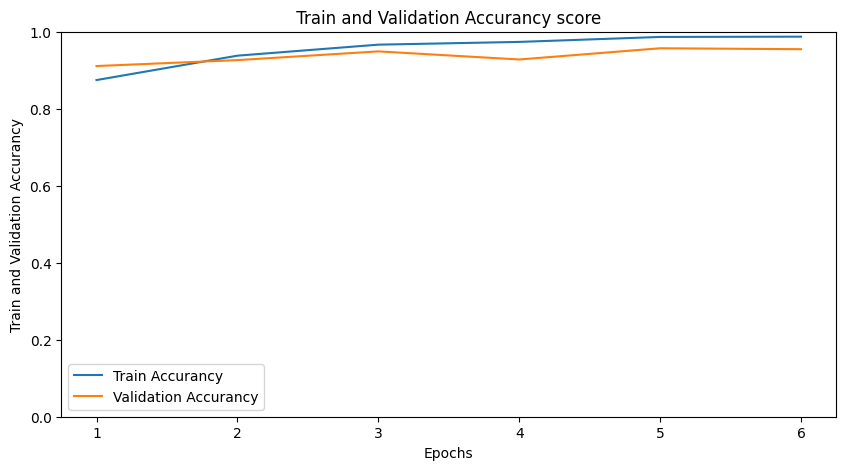

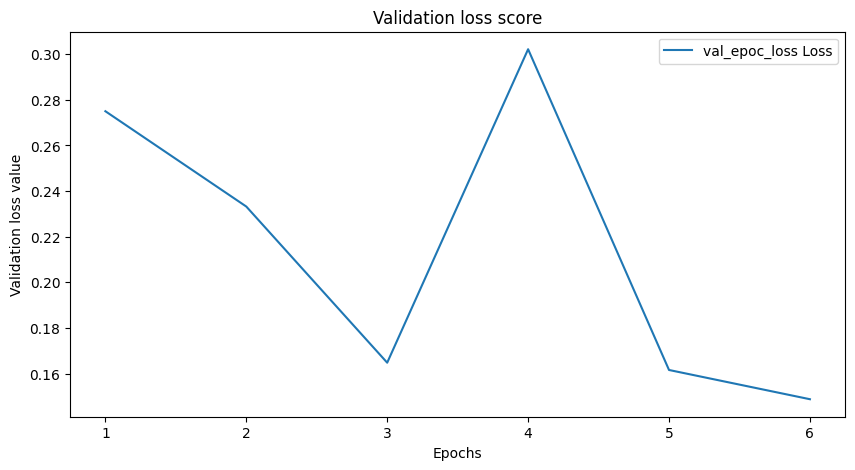

In [ ]:
import matplotlib.pyplot as plt

class Plot():
    def __init__(self, res):


        plt.figure(figsize =(10,5))
        plt.plot(res['tr_acc_sc'], label = 'Train Accurancy')
        plt.plot(res['val_acc_sc'], label = 'Validation Accurancy')
        plt.title(" Train and Validation Accurancy score ")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_acc_sc'])), [i for i in range(1, len(res['val_acc_sc']) + 1)])
        plt.ylabel('Train and Validation Accurancy')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

        plt.figure(figsize = (10, 5))
        plt.plot(res['val_epoc_loss'], label = "val_epoc_loss Loss")
        # plt.plot(res['val_loss'], label = "Validation Loss")
        plt.title("Validation loss score")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_epoc_loss'])), [i for i in range(1, len(res['val_epoc_loss']) + 1)])

        plt.ylabel("Validation loss value")
        # plt.ylim(0, 1.5)
        plt.legend()
        plt.show()
Plot(result)




In [ ]:
rasm = torch.rand(3,224,224)
print(rasm.shape)
print(rasm.unsqueeze(dim = 0).shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:

import random
def inference(data, model, device,rasmlar_soni,  class_name=None):
    bashoratlar, rasmlar = [], []

    for idx, batch in enumerate(data):
        if idx == rasmlar_soni: break
        rasm = batch
        print(type(rasm))
        rasmlar.append(rasm) # 3D
        bashorat = torch.argmax(model(rasm.unsqueeze(dim = 0).to(device)), dim = 1)
        bashoratlar.append(bashorat)

    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(rasmlar)-1) for _ in range(rasmlar_soni)]

    for idx, indeks in enumerate(indekslar):
        # im = rasmlar[indeks].squeeze() # 4D
        rasm = rasmlar[indeks]

        # plt.imshow(tensor_2_im(rasm))
        plt.imshow((rasm*255).cpu().permute(2,1,0).numpy().astype("uint8"))



        plt.axis("off")
        plt.title(f"PRED -> {class_name[bashoratlar[indeks]]}")
        plt.show()

# model = torch.load("modellar/sport_best_model.pt")
model = torch.load("best_model/sport_new_best_model.pth")
inference(data=ts_dl.dataset, model=model.to(device), device=device,rasmlar_soni=10,  class_name=list(class_names.keys()))

Output hidden; open in https://colab.research.google.com to view.

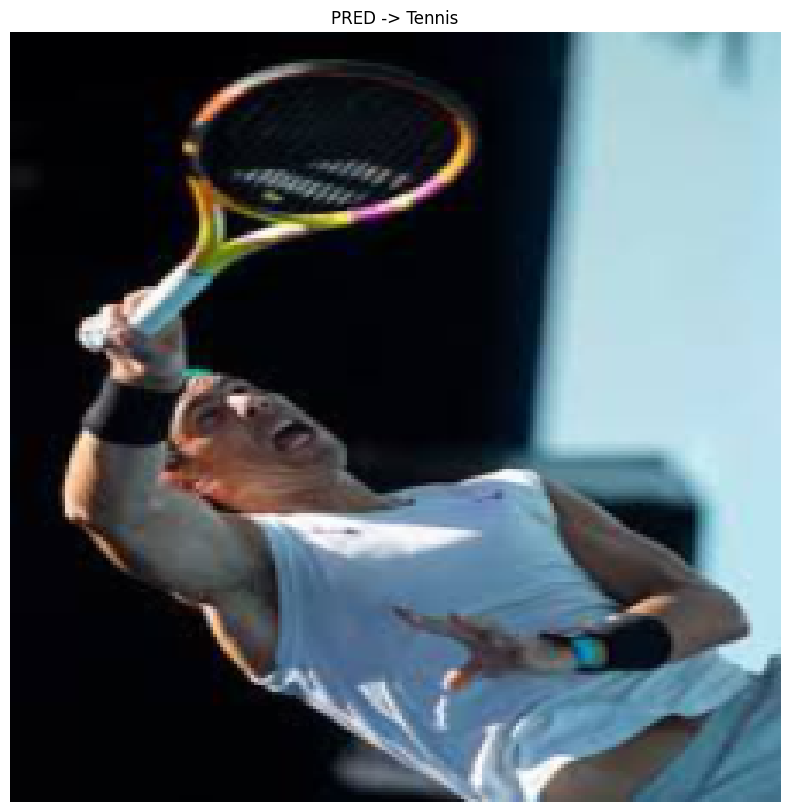

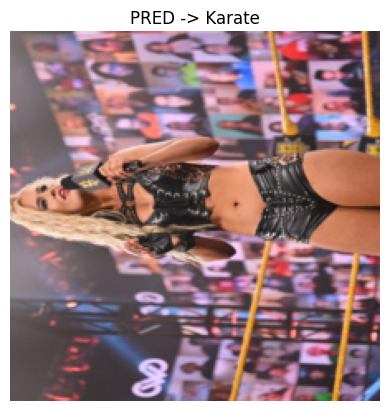

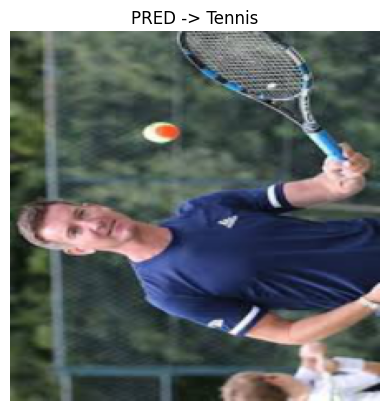

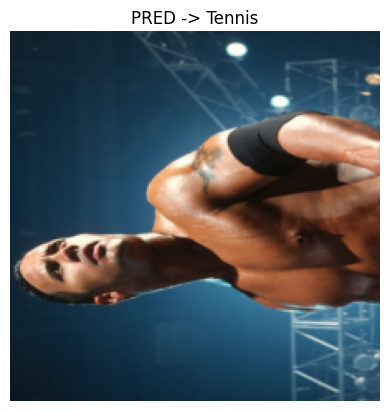

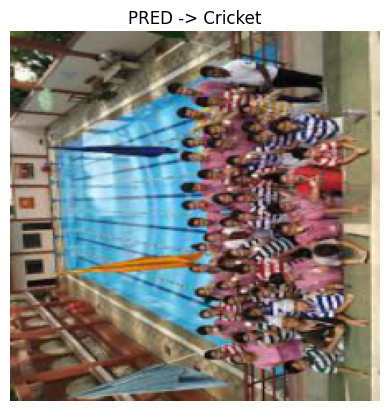

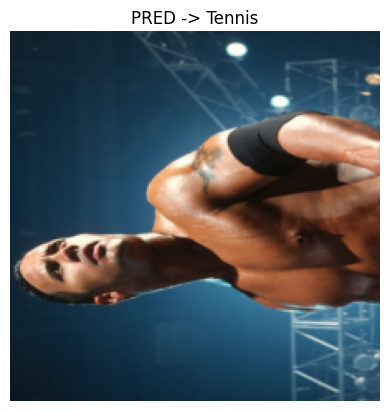

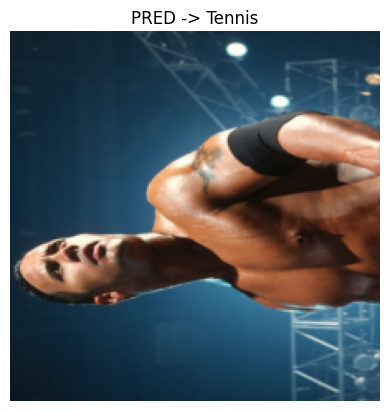

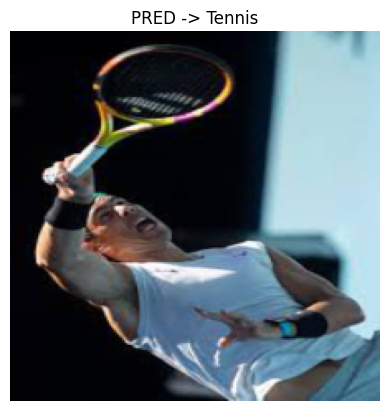

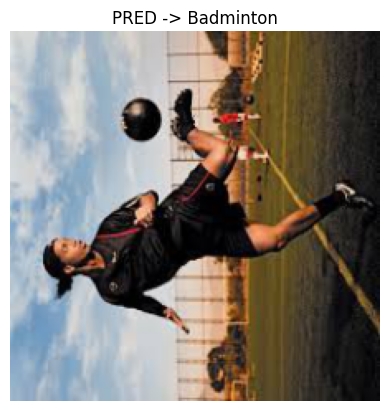

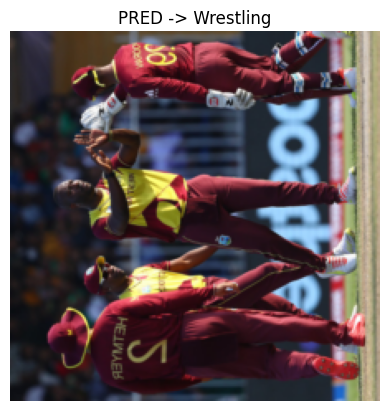

In [ ]:
#inference with Dataloader ts_dl

import random
def inference(data, model, device,rasmlar_soni,  class_name=None):
    bashoratlar, rasmlar = [], []

    for idx, batch in enumerate(data):
        if idx == rasmlar_soni: break
        rasm = batch
        rasmlar.append(rasm) # 3D
        bashorat = torch.argmax(model(rasm.to(device)), dim = 1)
        bashoratlar.append(bashorat)

    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(rasmlar)-1) for _ in range(rasmlar_soni)]

    batch_indeks = 5
    for idx, indeks in enumerate(indekslar):
        # im = rasmlar[indeks].squeeze() # 4D
        rasm = rasmlar[indeks]

        # plt.imshow(tensor_2_im(rasm))

        plt.imshow((rasm[batch_indeks]*255).cpu().permute(2,1,0).numpy().astype("uint8"))

        plt.axis("off")
        plt.title(f"PRED -> {class_name[bashoratlar[indeks][batch_indeks]]}")
        plt.show()

# model = torch.load("modellar/sport_best_model.pt")
model = torch.load("best_model/sport_new_best_model.pth")
inference(data=ts_dl, model=model.to(device), device=device,rasmlar_soni=10,  class_name=list(class_names.keys()))